In [1]:
%pip install cookiecutter-data-science

  Using cached cookiecutter_data_science-2.3.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached cookiecutter-2.6.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached tomlkit-0.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached binaryornot-0.4.4-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached rich-14.1.0-py3-none-any.whl.metadata (18 kB)
  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached cookiecutter_data_science-2.3.0-py3-none-any.whl (10 kB)
Using cached click-8.3.0-py3-none-any.whl (107 kB)
Using cached cookiecutter-2.6.0-py3-none-any.whl (39 kB)
Using cached tomlkit-0.13.3-py3-none-any.whl (38 kB)
Using cached binaryornot-0.4.4-py2.py3-none-any.whl (9.0 kB)
Using cached rich-14.1.0-py3-none-any.whl (243 kB)
Using cached chardet-5.2.0-py3-none-any.whl (199 

In [2]:
import os
import zipfile
import shutil
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset_name = "kamilpytlak/personal-key-indicators-of-heart-disease"
download_folder = Path("data/heart-disease")
download_folder.mkdir(parents=True, exist_ok=True)

api.dataset_download_files(dataset_name, path=str(download_folder), unzip=True)

base_dir = Path("data/heart-disease")
file_to_move = base_dir / "2020" / "heart_2020_cleaned.csv"
target_location = base_dir / "heart_2020_cleaned.csv"

# Przenieś plik
if file_to_move.exists():
    shutil.move(str(file_to_move), str(target_location))
    print(f"Przeniesiono: {file_to_move.name} → {target_location}")
else:
    print("Plik nie istnieje:", file_to_move)

# Usuń foldery 2020 i 2022
for folder in ["2020", "2022"]:
    folder_path = base_dir / folder
    if folder_path.exists() and folder_path.is_dir():
        shutil.rmtree(folder_path)
        print(f"Usunięto folder: {folder_path}")
    else:
        print(f"Folder nie istnieje: {folder_path}")

Dataset URL: https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease
Przeniesiono: heart_2020_cleaned.csv → data/heart-disease/heart_2020_cleaned.csv
Usunięto folder: data/heart-disease/2020
Usunięto folder: data/heart-disease/2022


In [3]:
#!dir "./data/heart-disease"

from pathlib import Path

folder = Path("./data/heart-disease")
for item in folder.iterdir():
    if item.is_file():
        print(f"{item.name}: {item.stat().st_size:,} bajtów")

heart_2020_cleaned.csv: 25,189,554 bajtów


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Wczytanie danych
df = pd.read_csv(download_folder / "heart_2020_cleaned.csv")

print(f"Kształt danych: {df.shape}")
print(f"\nKolumny:\n{df.columns.tolist()}")
print(f"\nTypy danych:\n{df.dtypes}")
print(f"\nPierwsze wiersze:")
print(df.head())

# Podział na train/test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['HeartDisease'])

# Przygotowanie X i y
y_train = df_train.pop("HeartDisease")
X_train = df_train

y_test = df_test.pop("HeartDisease")
X_test = df_test

print(f"\n{'='*50}")
print(f"Rozmiar train: {X_train.shape}")
print(f"Rozmiar test: {X_test.shape}")
print(f"\nRozkład target w train:")
print(y_train.value_counts())
print(f"\nRozkład procentowy:")
print(y_train.value_counts(normalize=True))

Kształt danych: (319795, 18)

Kolumny:
['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', 'SkinCancer']

Typy danych:
HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

Pierwsze wiersze:
  HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34   

In [5]:
import joblib
import optuna
from pathlib import Path
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

outfolder = Path("results")
outfolder.mkdir(parents=True, exist_ok=True)

best_params_path = outfolder / "best_params.pkl"

# Definiuj zmienne kategoryczne dla CatBoost
cat_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 
                'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 
                'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

if not best_params_path.is_file():
    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
    )
    
    def objective(trial):
        params = {
            "depth": trial.suggest_int("depth", 2, 10),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "iterations": trial.suggest_int("iterations", 100, 500),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 100.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.01, 1),
            "random_strength": trial.suggest_float("random_strength", 1e-5, 100.0, log=True),
            "auto_class_weights": "Balanced",  # Ważne dla nierównowagi klas!
            "random_seed": 42,
            "verbose": 0
        }
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train_opt, y_train_opt, 
            cat_features=cat_features,
            eval_set=(X_val_opt, y_val_opt), 
            early_stopping_rounds=50
        )
        
        return model.get_best_score()["validation"]["Logloss"]
    
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, show_progress_bar=True)
    
    joblib.dump(study.best_params, best_params_path)
    params = study.best_params
else:
    params = joblib.load(best_params_path)

print("Best Parameters:", params)

Best Parameters: {'depth': 3, 'learning_rate': 0.29946628479494963, 'iterations': 298, 'l2_leaf_reg': 6.489964129571064, 'bagging_temperature': 0.5948399857962691, 'random_strength': 2.4795266973526418}


In [6]:
from catboost import CatBoostClassifier, Pool, cv

params["eval_metric"] = "F1"
params["loss_function"] = "Logloss"
params["auto_class_weights"] = "Balanced"  

model = CatBoostClassifier(
    **params,
    verbose=True
)

# Pool z oznaczeniem zmiennych kategorycznych
data = Pool(
    X_train, 
    y_train,
    cat_features=cat_features  
)

cv_results = cv(
    params=params,
    pool=data,
    fold_count=5,
    partition_random_seed=42,
    shuffle=True,
    stratified=True  
)

cv_results.to_csv(outfolder / "cv_results_v2.csv", index=False)
print("\nWyniki CV:")
print(cv_results.describe())

Training on fold [0/5]
0:	learn: 0.6973447	test: 0.6956044	best: 0.6956044 (0)	total: 212ms	remaining: 1m 3s
1:	learn: 0.7443595	test: 0.7442392	best: 0.7442392 (1)	total: 331ms	remaining: 49s
2:	learn: 0.7386166	test: 0.7373217	best: 0.7442392 (1)	total: 502ms	remaining: 49.4s
3:	learn: 0.7608203	test: 0.7590926	best: 0.7590926 (3)	total: 643ms	remaining: 47.3s
4:	learn: 0.7663129	test: 0.7661870	best: 0.7661870 (4)	total: 773ms	remaining: 45.3s
5:	learn: 0.7586578	test: 0.7556890	best: 0.7661870 (4)	total: 916ms	remaining: 44.6s
6:	learn: 0.7617903	test: 0.7630652	best: 0.7661870 (4)	total: 1.07s	remaining: 44.5s
7:	learn: 0.7658842	test: 0.7668088	best: 0.7668088 (7)	total: 1.22s	remaining: 44.4s
8:	learn: 0.7664228	test: 0.7674412	best: 0.7674412 (8)	total: 1.33s	remaining: 42.7s
9:	learn: 0.7663547	test: 0.7662782	best: 0.7674412 (8)	total: 1.46s	remaining: 42s
10:	learn: 0.7668032	test: 0.7674357	best: 0.7674412 (8)	total: 1.57s	remaining: 40.9s
11:	learn: 0.7655679	test: 0.76669

In [7]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-F1-mean"], mode="lines", name="Mean F1 Score", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-F1-mean"]+cv_results["test-F1-std"], 
                     cv_results["test-F1-mean"]-cv_results["test-F1-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Performance Score",
    template="plotly_white",
    yaxis=dict(range=[0.5, 1])
)

fig.show()

fig.write_image(outfolder / "test_f1_v2.png")

/tmp/ipykernel_8477/2498414926.py:37: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




In [8]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add mean performance line
fig.add_trace(
    go.Scatter(
        x=cv_results["iterations"], y=cv_results["test-Logloss-mean"], mode="lines", name="Mean logloss", line=dict(color="blue")
    )
)

# Add shaded error region
fig.add_trace(
    go.Scatter(
        x=pd.concat([cv_results["iterations"], cv_results["iterations"][::-1]]),
        y=pd.concat([cv_results["test-Logloss-mean"]+cv_results["test-Logloss-std"], 
                     cv_results["test-Logloss-mean"]-cv_results["test-Logloss-std"]]),
        fill="toself", 
        fillcolor="rgba(0, 0, 255, 0.2)",
        line=dict(color="rgba(255, 255, 255, 0)"),
        showlegend=False
    )
)

# Customize layout
fig.update_layout(
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xaxis_title="Training Steps",
    yaxis_title="Logloss",
    template="plotly_white"
)

fig.show()

fig.write_image(outfolder / "test_logloss_v2.png")

/tmp/ipykernel_8477/2833190572.py:36: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




In [9]:
model = CatBoostClassifier(
    **params,
    verbose=True
)

model.fit(
    X_train,
    y_train,
    cat_features=cat_features,  
    verbose_eval=50,
    early_stopping_rounds=50,
    use_best_model=False,
    plot=True
)

model.save_model(outfolder / 'catboost_model_HeartDisease_v2.cbm')
joblib.dump(params, outfolder / 'model_params_v2.pkl')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7198546	total: 261ms	remaining: 1m 17s
50:	learn: 0.7749799	total: 7.98s	remaining: 38.7s
100:	learn: 0.7770264	total: 15.2s	remaining: 29.7s
150:	learn: 0.7775741	total: 22.2s	remaining: 21.6s
200:	learn: 0.7786236	total: 29.4s	remaining: 14.2s
250:	learn: 0.7791301	total: 36.6s	remaining: 6.86s
297:	learn: 0.7795741	total: 43.5s	remaining: 0us


['results/model_params_v2.pkl']

In [10]:
model.predict(df_test)

array(['Yes', 'No', 'No', ..., 'Yes', 'Yes', 'Yes'],
      shape=(63959,), dtype=object)

In [11]:
preds = model.predict(df_test[X_train.columns])

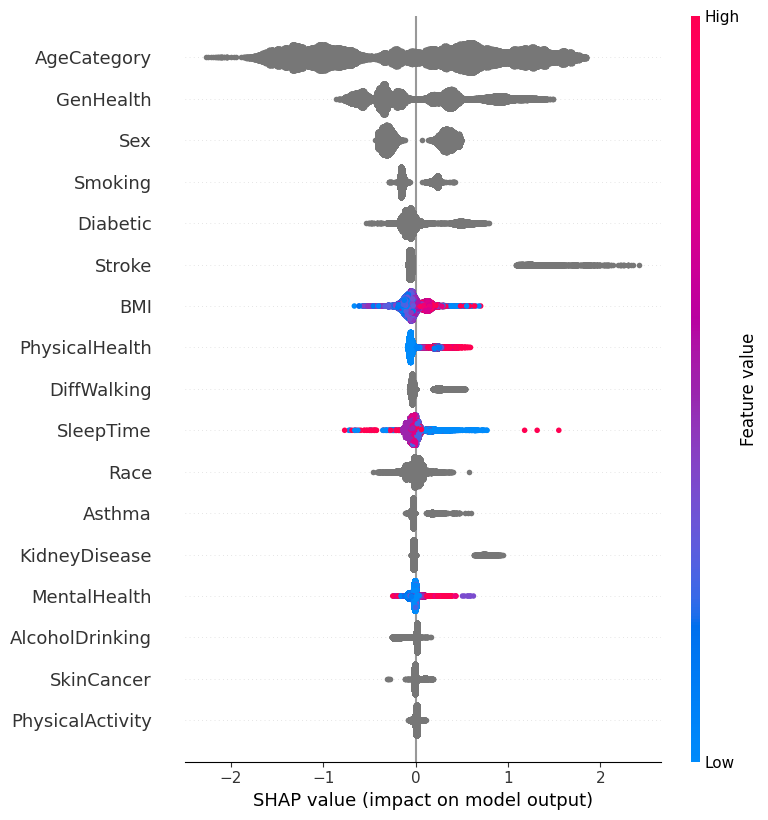

In [12]:
import shap
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test)

shap.summary_plot(shap_values, df_test, show=False)
plt.savefig(outfolder / "test_shap_overall_v2.png")

In [13]:
df_test["target"] = preds
df_test.to_csv(outfolder / "predictions_v2.csv", index=False)